In [127]:
#%matplotlib qt

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.
import ZebraLib as zb
from scipy.optimize import curve_fit

#Import de dados - Experimento
df = pd.read_excel('D:/UNESP/EngMec-UNESP/Lab. Mec Flu I/Relatório_4/dados_exp.xlsx', index_col=0)
df_calib = pd.read_excel('D:/UNESP/EngMec-UNESP/Lab. Mec Flu I/Relatório_4/curva_calibração_CQ.xlsx')

Dados utilizados para o experimento.

In [128]:
df

,h1,h2,delta_h,v_exp
0,2.7,17.4,14.7,28.43
1,16.5,4.0,12.5,27.75
2,15.7,4.8,10.9,26.04
3,14.8,5.8,9.0,23.95
4,13.9,6.8,7.1,21.70


## Solução polinomial - a curva não se ajusta

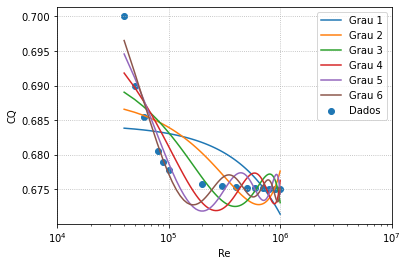

In [129]:
new_x = np.linspace(df_calib.x.min(), df_calib.x.max(),100)

fig, ax = plt.subplots()
ax.set(ylabel='CQ', xlabel='Re')

for i in range(1, 7):
    poly = zb.fit((df_calib.x), df_calib.y, i)
    ax.plot(new_x, poly(new_x), label =f'Grau {i}')

ax.scatter(df_calib.x, df_calib.y, label ='Dados')
ax.legend()
ax.grid(ls='dotted')
ax.set_xlim(1e4, 1e7)
ax.set_xscale('log')

## Solução hiperbolica usando curve_fit 
Melhor aproximação por mínimo quadrados utilizando a função genérica 
$f(x) = \frac{1}{x^a}b + c$

In [130]:
#Modelo
def func(x, a, b, c):
    return (1/(x**a))*b + c

#Fit do modelo
popt, pcov = curve_fit(func, df_calib.x, df_calib.y, p0=[1.9, 1, 0])

f(x) = 1/2.249*557813203.443 + 0.675


array([2.24901396e+00, 5.57813203e+08, 6.75097864e-01])

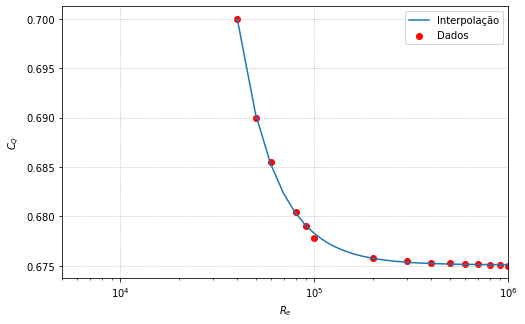

In [131]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.set(ylabel=r'$C_Q$', xlabel=r'$R_e$')

ax.plot(new_x, func(new_x, *popt), label =f'Interpolação')
ax.scatter(df_calib.x, df_calib.y, c='r', label ='Dados')

ax.legend()
ax.grid(ls='dotted')
ax.set_xlim(0.5e4, 1e6)
ax.set_xscale('log')

fig.savefig('aproxim.pdf', bbox_inches='tight')

#Resultados dos coeficientes p/ o melhor polinômio
print(f'f(x) = 1/{popt[0]:.3f}*{popt[1]:.3f} + {popt[2]:.3f}')
popt 

## Funções para auxiliar as iterações

In [132]:
D = 0.07816
area_D = (np.pi*(D**2))/4 

def coef_CQ(x):
    return func(x, *popt)

def Num_Re(v, D=0.07816):
    visc_din=15.06e-6 #Visc. dina. Ar 20ºC
    #rho_ar, visc_din_Ar = 1.205, 18.13e-6
    #return (v*D*rho_ar)/visc_din_Ar
    return (v*D)/visc_din
    
def Vazão_Q(cq, delta_h,  D=0.07816):
    rho_agua, rho_ar, g = 998.20, 1.205, 9.81
    Ad = 0.45*area_D
    delta_P = rho_agua*g*(delta_h)
    return cq*Ad*np.sqrt((2*delta_P)/rho_ar)

def iterador(delta_h, verbose=False, xtol=1e-5):
    v_sol = []
    Re = 1e6

    c=0
    while True:
        cq0 = coef_CQ(Re)
        Q = Vazão_Q(cq0, delta_h/100)
        V = Q/(area_D)                  #Velocidade do escoamento
        Re = Num_Re(V)
        
        if verbose:
            v_sol.append([cq0, Q, V, Re])
            if (c>2) and (abs(v_sol[c-1][2] - v_sol[c-2][2])<=xtol): #critério de convergencia
                break
        else:
            v_sol.append(V)
            if (c>2) and (abs(v_sol[c-1] - v_sol[c-2])<=xtol):
                v_sol = max(v_sol)
                break
        c = c + 1
    return (v_sol)


## Iterando para entrar o melhor valor

Calculando a vazão iterativamente para $\Delta h=14,7cm$ e expressando em forma de tabela.

In [133]:
#Iteração para o 1 valor de delta_h
pd.DataFrame(iterador(df.delta_h[0], True), columns=['CQ', 'Q', 'V', 'Re'])

,CQ,Q,V,Re
0,0.675116,0.071248,14.849580,77067.941309
1,0.680797,0.071848,14.974552,77716.534419
2,0.680691,0.071836,14.972212,77704.385987
3,0.680693,0.071837,14.972255,77704.610509
4,0.680693,0.071837,14.972254,77704.606359


Tabela das velocidades teoricas após ser atingido o critério de convergência comparadas com a velocidade experimental e o erro em % associado. 

In [134]:
#Calculando as velocidades teóricas e comparando
F = []
for i in df.delta_h:
    F.append(iterador(i, False))
pd.DataFrame({'VT':F, 'VE':df.v_exp, 'ER':abs(df.v_exp-F)/F*100})

,VT,VE,ER
0,14.974552,28.43,89.855426
1,13.831735,27.75,100.625584
2,12.937775,26.04,101.271087
3,11.789218,23.95,103.151723
4,10.517341,21.70,106.325909
